In [1]:
import pandas as pd 
import copy
import itertools
import math
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import log_loss
from scipy import optimize
from sklearn.svm import SVC
from sklearn.utils import shuffle

In [2]:
compas = pd.read_csv('/Users/lsx/Desktop/Fall2021-Project4-group5-main/data/compas-scores-two-years.csv')

In [3]:
def processing_compas(compas): 
    #drop Missing values
    compas.dropna()
    compas_subset = compas[["sex","age","age_cat","race","priors_count","c_charge_degree","c_jail_in", "c_jail_out",'two_year_recid']]
    compas_subset["two_year_recid"] = compas_subset["two_year_recid"].apply(lambda x: -1 if x==0 else 1)
    #ecnoding Caucasian race is 0, African American is 1
    compas_subset = compas_subset[(compas_subset["race"]=='Caucasian') |(compas_subset["race"]=='African-American') ]
    compas_subset["race_cat"] = compas_subset["race"].apply(lambda x: 1 if x == "Caucasian" else 0)
    compas_subset = compas_subset.drop(columns = "race")
    #encoding female is 1 and male is 0
    compas_subset["gender_cat"] = compas_subset["sex"].apply(lambda x: 1 if x == "Female" else 0)
    compas_subset = compas_subset.drop(columns = "sex")
    #encoding 'F' charge degree is 1  
    compas_subset["charge_cat"] = compas_subset["c_charge_degree"].apply(lambda x: 1 if x == "F" else 0)
    compas_subset = compas_subset.drop(columns = "c_charge_degree")
    #length of stay = jail out - jail in 
    #Categorize length_stay with 0/1/2
    compas_subset["length_stay"] = pd.to_datetime(compas_subset["c_jail_out"]) - pd.to_datetime(compas_subset['c_jail_in'])
    compas_subset["length_stay"] = compas_subset["length_stay"].apply(lambda x: x.days)
    compas_subset = compas_subset.drop(columns = ["c_jail_in","c_jail_out"])
    compas_subset['length_stay'] = compas_subset["length_stay"].apply(lambda x: 0 if x <= 7 else x)
    compas_subset['length_stay'] = compas_subset["length_stay"].apply(lambda x: 1 if 7< x <= 90 else x)
    compas_subset['length_stay'] = compas_subset["length_stay"].apply(lambda x: 2 if x > 90 else x)
    #Categorize priors count into 0/1/2
    compas_subset["priors_count"] = compas_subset["priors_count"].apply(lambda x: 0 if x==0 else x)
    compas_subset["priors_count"] = compas_subset["priors_count"].apply(lambda x: 1 if (1<=x<=3) else x)
    compas_subset["priors_count"] = compas_subset["priors_count"].apply(lambda x: 2 if x>3 else x)
    #encoding age_cat  as dummies
    dummies = pd.get_dummies(compas_subset["age_cat"])
    compas_subset = pd.merge(compas_subset, dummies, left_index = True, right_index = True)
    compas_subset = compas_subset.drop(columns = ["age_cat","age"])
    
    compas_subset = compas_subset.dropna()
    y_label = compas_subset["two_year_recid"]
    protected_attribute = compas_subset["race_cat"]
    df = compas_subset.drop(columns=["two_year_recid","race_cat"])

    y_label, protected_attr, df = shuffle(y_label, protected_attribute, df, random_state = 0)

    return y_label.to_numpy(), protected_attr.to_numpy(), df.to_numpy()

In [4]:
def accuracy(w, x, y):
  shape = x.shape[1]
  pred = np.dot(x, w.reshape(shape,1))
  pred_prob = 1/(1+ 2.718**(-pred))
  
  pred_prob[pred_prob>=0.5] = 1
  pred_prob[pred_prob<0.5] = -1

  matches = np.where(pred_prob== y.reshape(pred_prob.shape))

  return (matches[0].shape[0]/pred_prob.shape[0]), pred_prob

#Define p% rule ratio 
def p_rule(race_var, predicted_y):
  
  not_protected = np.where(race_var != 1)[0]
  protected = np.where(race_var == 1)[0] 

  protected_preds = np.where(predicted_y[protected] == 1)
  nonpro_preds = np.where(predicted_y[not_protected] == 1)
  protected_perc = (protected_preds[0].shape[0]/protected.shape[0]) 
  nonpro_perc = (nonpro_preds[0].shape[0]/not_protected.shape[0])

  perc_ratio = protected_perc/nonpro_perc

  return perc_ratio, protected_perc, nonpro_perc



In [5]:
y_label, protected_attr, X =  processing_compas(compas)

train_index = int(len(X)*.80)
x_train, y_train, race_train = X[:train_index], y_label[:train_index], protected_attr[:train_index]
x_test, y_test, race_test = X[train_index:], y_label[train_index:],protected_attr[train_index:]

/var/folders/fk/z7v3jbsd74q31y7nyk6xvmj80000gn/T/ipykernel_3302/1396295897.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compas_subset["two_year_recid"] = compas_subset["two_year_recid"].apply(lambda x: -1 if x==0 else 1)
/var/folders/fk/z7v3jbsd74q31y7nyk6xvmj80000gn/T/ipykernel_3302/1396295897.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compas_subset["race_cat"] = compas_subset["race"].apply(lambda x: 1 if x == "Caucasian" else 0)


In [6]:
clf = LogisticRegression(random_state=0).fit(x_train, y_train)
print(f"Logistic Regression Accuracy: {clf.score(x_train, y_train)}")
print(f"P%-rule: {p_rule(race_train, clf.predict(x_train))}")
coeff = clf.coef_
intercept = clf.intercept_
optimal_loss = log_loss(y_train, clf.predict_proba(x_train))

Logistic Regression Accuracy: 0.6642011834319527
P%-rule: (0.5974526902979804, 0.32718651211801897, 0.547635850388144)


In [7]:
print(f"Logistic Regression Accuracy: {clf.score(x_test, y_test)}")
p_rule(race_test, clf.predict(x_test))

Logistic Regression Accuracy: 0.661876584953508


(0.6573326771653544, 0.35625, 0.5419630156472262)

In [8]:
#reshaping arrays 
#and then calcualte distribution from decision boundary 

ind = x_train.shape[0]
ind_test = x_test.shape[0] 

lift = np.ones(ind).reshape(ind, 1)
lift_test = np.ones(ind_test).reshape(ind_test, 1)
x_test =  np.concatenate((x_test, lift_test), axis = 1)
x_train = np.concatenate((x_train, lift), axis = 1)

optimal_weights_compas = np.concatenate((coeff, intercept.reshape(1,1)), axis = 1)

**Logistic regression**
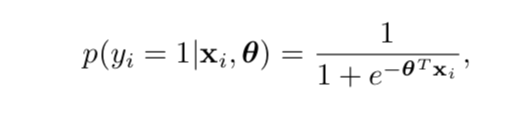

**Maximizing Fairness Under Accuracy Constraints**
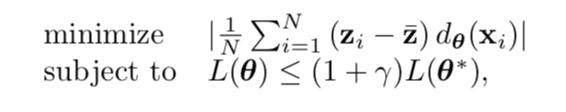

**Fine-Grained Accuracy Constraints**
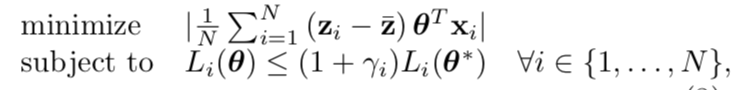

In [9]:


#creating Constraints for optimization 
def logisitc_loss(weights, X, y):
  
  shape = x_train.shape[1]
  dp = np.dot(X, weights.reshape(shape,1))
  dp = dp.astype(np.float64)
  pred_prob = 1/(1+ 2.718**(-dp))

  pred_classes = np.concatenate((1-pred_prob, pred_prob), axis = 1)
  loss = log_loss(y, pred_classes)

  return loss 
#constraint1: Maximizing Fairness Under Accuracy Constraints
def constraint1(weights, x, y, gamma):
  
  upd_loss = logisitc_loss(weights, x, y)

  return (1+gamma)*optimal_loss - upd_loss 

#Optmization function to minimize 
def opt_function(w, x, protected_var):
  
  dist_bound = np.dot(w, x_train.T)
  protected_cov = (protected_var - np.mean(protected_var)) * dist_bound
  
  return float(abs(sum(protected_cov))) / float(x_train.shape[0])

- reference: https://towardsdatascience.com/optimization-with-scipy-and-application-ideas-to-machine-learning-81d39c7938b8

In [10]:
##Run a single optimization with a defined Gamma 
def run_optimization(x_train, y_train, x_test, y_test, protected_attr, protected_attr_test, gamma, optimal_weights):
    constraints = []
    cons = {'type':'ineq', 'fun': constraint1, 'args': (x_train, y_train, gamma)}

    result = optimize.minimize(opt_function,
                               x0=optimal_weights,
                               args= (x_train,protected_attr),
                               method='SLSQP',
                               constraints=cons,
                               options={'maxiter':10000})
    
    accuracy_train, pred_y = accuracy(result.x, x_train, y_train)
    p_rule_val, prot_perc, nonp_perc = p_rule(protected_attr, pred_y)
    
    accuracy_test, y_pred_test = accuracy(result.x, x_test, y_test)
    p_rule_val_test, prot_perc_test, nonp_perc_test = p_rule(protected_attr_test, y_pred_test)
    
    print(f"Accuracy for gamma {gamma}: {accuracy_train}")
    print(f"P Rule Value: {p_rule_val}")
    print (f"Perc of protected vs non protected in positive class: {prot_perc}: {nonp_perc}")
    
    return accuracy_train,pred_y, p_rule_val, prot_perc, nonp_perc, accuracy_test, p_rule_val_test, prot_perc_test, nonp_perc_test 




In [11]:
#Run multiple optimizations for multiple gammas values
def run_mult_optmizations(x_train, y_train, x_test,y_test, protected_attr, protected_attr_test, optimal_weights, gamma_list):
    
    accuracy_list, p_val_list, prot_perc_list, nonpro_perc_list = [],[],[],[]
    accuracy_list_test, p_val_list_test, prot_perc_list_test, nonpro_perc_list_test = [],[],[],[]
    for g in gamma_list: 
        (accuracy_train, pred_y, p_rule_val, prot_perc, nonp_perc,
        accuracy_test, p_rule_val_test, prot_perc_test, nonp_perc_test) = run_optimization(x_train, 
                                                                                          y_train,
                                                                                          x_test,
                                                                                          y_test,
                                                                                          protected_attr, 
                                                                                          protected_attr_test,
                                                                                          g, 
                                                                                          optimal_weights)
        accuracy_list.append(accuracy_train)
        p_val_list.append(p_rule_val)
        prot_perc_list.append(prot_perc)
        nonpro_perc_list.append(nonp_perc)
        
        accuracy_list_test.append(accuracy_test)
        p_val_list_test.append(p_rule_val_test)
        prot_perc_list_test.append(prot_perc_test)
        nonpro_perc_list_test.append(nonp_perc_test)
        
    return accuracy_list, p_val_list, prot_perc_list, nonpro_perc_list,accuracy_list_test, p_val_list_test, prot_perc_list_test, nonpro_perc_list_test
        
    

In [12]:
#Run optimization for different gamma values

In [13]:
(compas_acc, compas_p_val_list, compas_protected, compas_nonpro, 
 compas_acc_test, compas_p_val_list_test, compas_protected_test, compas_nonpro_test) = run_mult_optmizations(x_train, 
                                                                                y_train, 
                                                                                x_test, 
                                                                                y_test, 
                                                                                race_train,
                                                                                race_test, 
                                                                                optimal_weights_compas, 
                                                                                [0.05,0.1,0.11])

Accuracy for gamma 0.05: 0.6299661876584953
P Rule Value: 0.6802906157982332
Perc of protected vs non protected in positive class: 0.3082191780821918: 0.45306986591390264
Accuracy for gamma 0.1: 0.5617075232459848
P Rule Value: 0.9035258405977584
Perc of protected vs non protected in positive class: 0.2244467860906217: 0.24841213832039521
Accuracy for gamma 0.11: 0.5420540997464074
P Rule Value: 1.0219080928786552
Perc of protected vs non protected in positive class: 0.10168598524762908: 0.0995059985885674


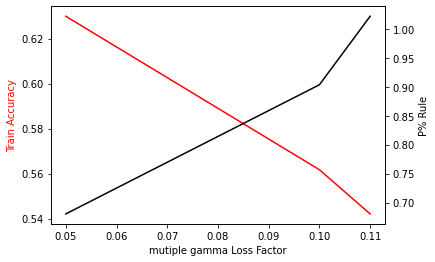

In [14]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( [0.05,0.1,0.11], compas_acc , 'r-')
ax2.plot( [0.05,0.1,0.11], compas_p_val_list, 'k-')

ax1.set_xlabel('mutiple gamma Loss Factor')
ax1.set_ylabel('Train Accuracy', color='r')
ax2.set_ylabel('P% Rule', color='k')

plt.show()

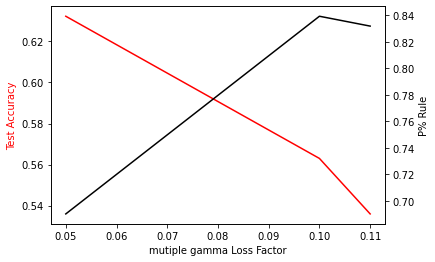

In [15]:

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( [0.05,0.1,0.11], compas_acc_test , 'r-')
ax2.plot( [0.05,0.1,0.11], compas_p_val_list_test, 'k-')

ax1.set_xlabel('mutiple gamma Loss Factor')
ax1.set_ylabel('Test Accuracy', color='r')
ax2.set_ylabel('P% Rule', color='k')

plt.show()